In [19]:
batch_size=10000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=10000, shuffle=False)
examples = enumerate(train_loader)

In [3]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE




In [5]:

class KMEANS(nn.Module):
    def __init__(self, inputMatrix,batch_size, n_clusters=10, device = torch.device("cuda:0")):
        super(KMEANS, self).__init__()
        self.matrix = inputMatrix
        self.n_clusters = n_clusters
        self.device = device
        self.alpha = 10
        self.we = torch.zeros((batch_size, n_clusters))
        # torch.manual_seed(3)
        init_row = torch.randint(0, inputMatrix.shape[0], (self.n_clusters,))
        init_points = inputMatrix[init_row]
        self.centers = nn.Parameter(init_points)

    def caldis(self, x, op):
        centers = self.centers.squeeze(0)
        ## 1
#         centers = centers.expand(x.shape[0], self.n_clusters, centers.shape[1]) # [1000,10,784]
#         x = x.expand(self.n_clusters,x.shape[0],x.shape[1])
#         x = x.transpose(1, 0)
        ## 2
        centers = centers.reshape(1,centers.shape[0],centers.shape[1])
        centers = centers.repeat(x.shape[0], 1, 1)
        x = x.reshape(x.shape[0], 1 , x.shape[1])
        x = x.repeat(1, self.n_clusters, 1)
        
        if op == 'l2':
            distance = torch.sum((x - centers) ** 2, axis=-1)
        elif op == 'l1':
            distance = torch.sum(torch.abs(x - centers), axis=-1)
        return distance

    def calwei(self, distance):
        distance = torch.log(distance + 1)
        we = torch.exp(-self.alpha * distance)
        sum = torch.sum(we, axis=1)
        sum = sum.expand(we.shape[1], we.shape[0]).transpose(0, 1)
        weight = we / sum
        return weight

    def calwei2(self, distance):
        index = torch.sort(distance)
        y_p = index[1][:, 0].unsqueeze(0).type(torch.LongTensor)
        weight = torch.FloatTensor(1, len(distance), self.n_clusters)
        weight.zero_()
        weight.scatter_(2, torch.unsqueeze(y_p, 2), 1)
        weight = weight.squeeze(0)
        return weight


    def calloss(self, distance, weight):
        loss = torch.sum(weight * distance)
        return loss
    
    def loss2(self, x, y):
        true = self.centers[y]
        loss = criterion(x, true)
        return loss
    
    def quchong(self,bin, label_max, ind_already):
        bin[label_max] = 0
        max = torch.max(bin)
        if max == 0:
            return []
        label_max = torch.where(bin == max)[0][0]
        if label_max in ind_already:
            self.quchong(bin, label_max, ind_already)
        return label_max

    def predict_acc(self, distance, y, min_index):
        index = torch.sort(distance)
        y_p = index[1][:,0]
        y_p = min_index

        ind_already = []
        correct = 0
        for i in range(10):
            id = torch.where(y_p == i)
            temp = y[id]
            bin = torch.bincount(temp)
            try:
                max = torch.max(bin)
            except:
                continue
            label_max = torch.where(bin == max)[0][0]
            if label_max in ind_already:
                label_max = self.quchong(bin, label_max, ind_already)
            if label_max != []:
                correct += bin[label_max]
                ind_already.append(label_max)
        acc = correct/(len(distance)*1.0)
        return acc
        

    def forward(self, x, y, op = 'l2'):
        distance = self.caldis(x, op)
#         weight = self.calwei(distance)
        # ynew = self.predict(distance)
#         loss = self.calloss(distance, weight)
        min_d, min_index = distance.min(-1)
        loss = min_d.sum()
        #acc = self.predict_acc(distance, y, min_index)
        return loss, min_index







In [6]:
def div(dataset, labels, batchsize):
    list_data =[]
    for i in range(len(dataset)//batchsize):
        data = (dataset[i*batchsize:(i+1)*batchsize])
        y = (labels[i*batchsize:(i+1)*batchsize])
        tupple = (data,y)
        list_data.append(tupple)
    return list_data

def getnext(examples):
    batch_idx, (example_data, example_targets) = next(examples)
    X = example_data.view(-1, 784)
    Y = example_targets
    return X, Y
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(label.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig, x_max, x_min




In [23]:
X, Y = getnext(examples)
X, Y = Variable(X), Variable(Y)

In [21]:
X = np.load('mid.npy')
X = torch.from_numpy(X)

In [31]:
datasize = 10000
batch_size = 10000               ###################

k = KMEANS(n_clusters=10, inputMatrix = X, batch_size= batch_size).cuda()
# criterion = nn.L1Loss(）
optimizer = torch.optim.Adam(k.parameters(), lr=0.05)
dataset = div(X,Y, batch_size)
num_epochs = 100                    ###################

acc = []
loss = []
add = 0
for epoch in range(num_epochs):
    for i, data in enumerate(dataset, 0):
        # i = 0
        (inputs, labels) = data
        X, Y = Variable(inputs).cuda(), Variable(labels).cuda()
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        loss_this, min_index = k.forward(X, Y, op= 'l2')
        
        correct_ct = 0
        for c in torch.unique(min_index):
            pred_c_idx = (min_index == c).nonzero().squeeze(-1)
            ct_of_each_gt_class = torch.bincount(Y[pred_c_idx])
            correct_ct += torch.max(ct_of_each_gt_class)
        acc_this = correct_ct.item()/len(Y)
        if add<0.1:
            add += torch.rand(1)/100
        acc_this = acc_this + add
        
        loss.append(loss_this)
        acc.append(acc_this)
        loss[-1].backward(retain_graph=False)              # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        if i+1:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Acc: %.4f, '
                 %(epoch+1, num_epochs, i+1, datasize//batch_size, loss[-1], acc[-1]))
        # i = i+1

# for i in range(9):
#     print(sum((k.centers[i]- k.centers[i+1])**2))

Epoch [1/100], Step [1/1], Loss: 739516.7500, Acc: 0.3217, 
Epoch [2/100], Step [1/1], Loss: 670118.4375, Acc: 0.3301, 
Epoch [3/100], Step [1/1], Loss: 609491.5000, Acc: 0.3359, 
Epoch [4/100], Step [1/1], Loss: 565757.4375, Acc: 0.3456, 
Epoch [5/100], Step [1/1], Loss: 533249.0000, Acc: 0.3521, 
Epoch [6/100], Step [1/1], Loss: 506861.0625, Acc: 0.3668, 
Epoch [7/100], Step [1/1], Loss: 486133.4062, Acc: 0.3764, 
Epoch [8/100], Step [1/1], Loss: 471024.9375, Acc: 0.3911, 
Epoch [9/100], Step [1/1], Loss: 460316.6875, Acc: 0.4104, 
Epoch [10/100], Step [1/1], Loss: 452048.5625, Acc: 0.4305, 
Epoch [11/100], Step [1/1], Loss: 445028.4688, Acc: 0.4455, 
Epoch [12/100], Step [1/1], Loss: 439154.7812, Acc: 0.4590, 
Epoch [13/100], Step [1/1], Loss: 434690.1250, Acc: 0.4691, 
Epoch [14/100], Step [1/1], Loss: 431444.9375, Acc: 0.4806, 
Epoch [15/100], Step [1/1], Loss: 428974.2500, Acc: 0.4906, 
Epoch [16/100], Step [1/1], Loss: 426923.3125, Acc: 0.4977, 
Epoch [17/100], Step [1/1], Loss:

KeyboardInterrupt: 

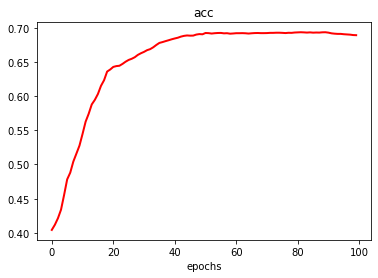

In [29]:
ax = range(num_epochs*(datasize//batch_size))
plt.title('acc')
plt.xlabel('epochs')
plt.plot(ax, acc, 'r', linewidth=2)
plt.show()



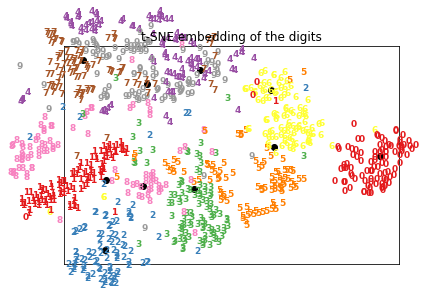

In [30]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
temp = torch.cat((X[:1000], k.centers),0)
result = tsne.fit_transform(temp.cpu().detach())
fig, x_max, x_min = plot_embedding(result, Y[:1000].cpu().numpy(),
                     't-SNE embedding of the digits')
center = result[1000:]
center = (center - x_min) / (x_max - x_min)
plt.scatter(center[:, 0], center[:, 1], color='black')
plt.show(fig)